<a href="https://colab.research.google.com/github/stemarzo/DISME/blob/main/04_fourth_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SIFT: Scale -invariant Feature Transform

### Librerie

In [ ]:
import cv2 as cv
print(cv.__version__)

3.4.2


ultima versione di opencv che permette di usare SIFT è la 3.4.2

In [ ]:
!pip install opencv_contrib_python==3.4.2.17 --force-reinstall 

  Using cached opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl (30.6 MB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 whic

In [ ]:
import cv2 as cv
print(cv.__version__)


3.4.2


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [15, 5] 

Non usiamo la libreria usata la scorsa volta, in quanto dopo utilizzando opencv, per non avere problemi utilizziamo già quella anche per caricare le img.

### Carico immagine

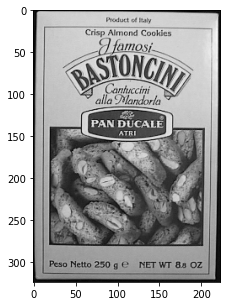

In [ ]:
box = cv.imread('images/box.png', 
                0) #0 scala di grigi
plt.imshow(box, cmap='gray'); plt.show()

### Utilizzo di SIFT

Ci sono diverse difficoltà, l'immagine risulta più piccola, ruotata e con una diversa prospettiva nell'immagine target.

In [ ]:
#instanziare SIFT
sift = cv.xfeatures2d.SIFT_create()

In [ ]:
kps1, features1 =sift.detectAndCompute(box, None)

i keypoints sono una lista che contiene tot elementi, che potrebbero essere potenzialmente utili per cercare la stessa immagine da un'altra parte

In [ ]:
len(kps1)

604

Sono di tipo proprietario di OpenCV

In [ ]:
type(kps1[0])

cv2.KeyPoint

Guardando cosa contiene, ci sono molte variabili con gli underscore che vengono usate da funzione specifiche per l'elaborazione, infine ci sono alcune variabili che possono servirmi:
- Angle, mi dice la rotazione di questi angoli;
- Octave, specifica la scala al quale è stato trovato il punto.
- pt, più importante per noi, le coordinate del punto

In [ ]:
dir(kps1[0])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'angle',
 'class_id',
 'convert',
 'octave',
 'overlap',
 'pt',
 'response',
 'size']

In [ ]:
kps1[0].pt

(3.161376476287842, 204.0614776611328)

Abbiamo trovato i punti, ora servono delle feature che li descrivono.

In [ ]:
features1.shape

(604, 128)

KeyPoint Visualization

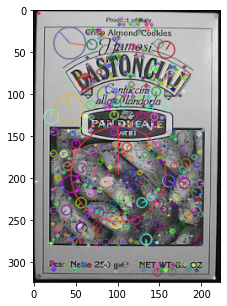

In [ ]:
box_kps	=	cv.drawKeypoints(	box, kps1, None, flags= cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(box_kps, cmap='gray');

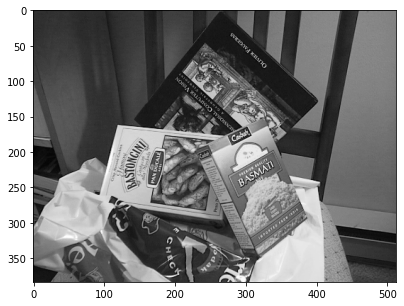

In [ ]:
scene = cv.imread('images/box_in_scene.png',0)
kps2, features2 = sift.detectAndCompute(scene, None)
plt.imshow(scene, cmap="gray")

Inizia la parte di matching, cioè associare i punti della prima immagine alla seconda.

Non tutti corrisponderanno.

Utilizzeremo un brute-force matcher

In [ ]:
len(kps2)

969

In [ ]:
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [ ]:
len(matches)

398

In [ ]:
type(matches[0])

cv2.DMatch

Informazioni che ci interessano:
- distance, non è la distanza nello spazio, ma è la distanza nello spazio delle feature (valori bassi punti simili)
- imgIdx
- queryIdx: indice della prima immagine(per la coppia corrente)
- trainIdx: indice della seconda immagine(per la coppia corrente)

In [ ]:
print(dir(matches[0])) 

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']


In [ ]:
matches[1].queryIdx

1

In [ ]:
matches[1].trainIdx

336

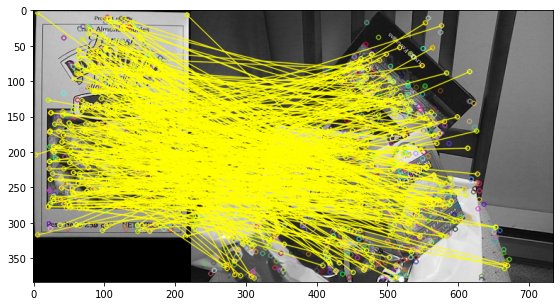

In [ ]:
result = cv.drawMatches(box, kps1, scene, kps2, matches, None, matchColor=[255,255,0])
plt.imshow(result, cmap="gray")

il problema che ha trovato un sacco di false positive e questo non può andare bene.

Si cerca di utilizzare distance per filtrare un po' i false positive

Riodiniamo matches in modo tale che i primi match abbiano distanza bassa, utilizziamo funzione sorted.

In [ ]:
matches=sorted(matches, key=lambda x: x.distance)

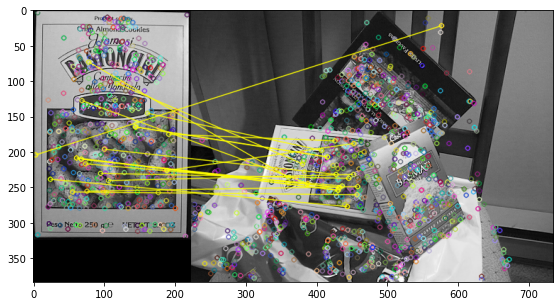

In [ ]:
result = cv.drawMatches(box, kps1, scene, kps2, matches[0:20], 
                        None, matchColor=[255,255,0])
plt.imshow(result, cmap="gray")

### Panorama: Image Stitching

Immagine BOAT

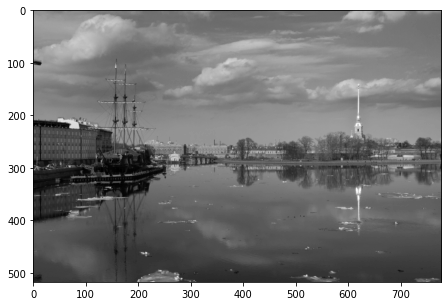

In [ ]:
boat1 = cv.imread('images/boat1.jpg', 0)
plt.imshow(boat1, cmap='gray'); plt.show()

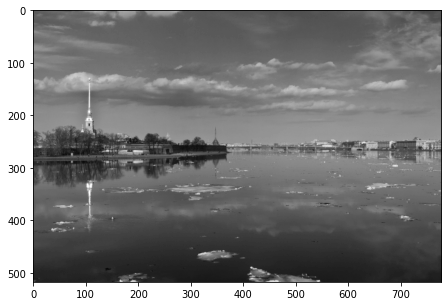

In [ ]:
boat3 = cv.imread('images/boat3.jpg', 0)
plt.imshow(boat3, cmap='gray'); plt.show()

Calcolo keypoints e feature di entrambe

In [ ]:
sift=cv.xfeatures2d.SIFT_create()

In [ ]:
kpsb1, featuresb1 =sift.detectAndCompute(boat1, None)

In [ ]:
kpsb3, featuresb3 =sift.detectAndCompute(boat3, None)

Associare i descrittori con il matcher

In [ ]:
bf=cv.BFMatcher(crossCheck=True)
matchesb=bf.match(featuresb3, featuresb1)

In [ ]:
matchesb_sort = sorted(matchesb, key=lambda x: x.distance)[1:100]

Step1: trovare omografia che descrive la trasformazione tra il secondo set di keypoints e il primo

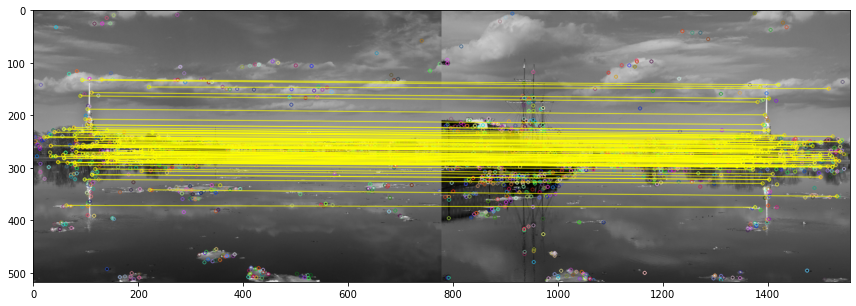

In [ ]:
result = cv.drawMatches(boat3, kpsb3, boat1, kpsb1, matchesb_sort, 
                        None, matchColor=[255,255,0])
plt.imshow(result, cmap="gray")

In [ ]:
def myHomografy(kpsA, kpsB, matches):
  kpsA = np.float32([kp.pt for kp in kpsA])
  kpsB = np.float32([kp.pt for kp in kpsB])
  
  ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
  ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

  h, status = cv.findHomography(ptsA, ptsB, cv.RANSAC,
            4)
  return h

In [ ]:
H = myHomografy(kpsb3, kpsb1, matchesb_sort)

In [ ]:
print(H)

[[ 5.73189861e-01 -8.92308542e-03  5.21084742e+02]
 [-1.51227482e-01  9.19674399e-01  2.97776987e+01]
 [-5.46775649e-04 -1.57420007e-05  1.00000000e+00]]


Step2: applicare l'omografia alla seconda immagine

In [ ]:
def myWarp(im_base, im_train, H):
  width = im_base.shape[1] + im_train.shape[1]
  height = im_base.shape[0]
  return cv.warpPerspective(im_train, H, (width, height))

In [ ]:
img_final=myWarp(boat1, boat3, H)

Integrare la prima immagine

In [ ]:
def myCollage(im_base, im_train_warp):
  im_train_warp[0:im_base.shape[0], 0:im_base.shape[1]] = im_base
  plt.imshow(im_train_warp, cmap="gray")

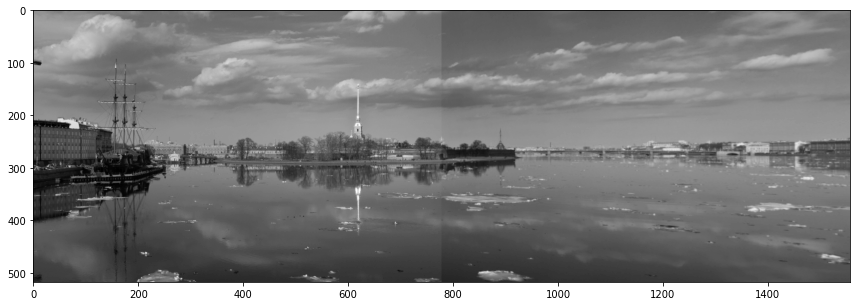

In [ ]:
myCollage(boat1,img_final)


### Panorama Mio

Carico immagini

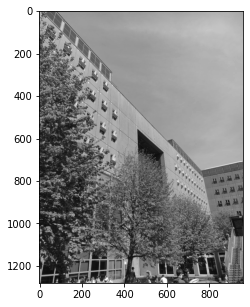

In [256]:
img1 = cv.imread('fot4.jpg', 0)
plt.imshow(boat1, cmap='gray'); plt.show()

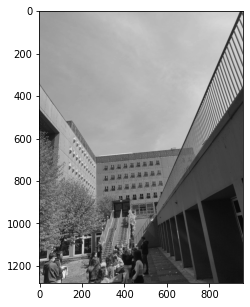

In [257]:
img3 = cv.imread('fot3.jpg', 0)
plt.imshow(boat3, cmap='gray'); plt.show()

Calcolo keypoints e feature di entrambe

In [258]:
sift=cv.xfeatures2d.SIFT_create()

In [259]:
kpsb1, featuresb1 =sift.detectAndCompute(img1, None)

In [260]:
kpsb3, featuresb3 =sift.detectAndCompute(img3, None)

Associare i descrittori con il matcher

In [261]:
bf=cv.BFMatcher(crossCheck=True)
matchesb=bf.match(featuresb3, featuresb1)

In [262]:
matchesb_sort = sorted(matchesb, key=lambda x: x.distance)[1:100]

Step1: trovare omografia che descrive la trasformazione tra il secondo set di keypoints e il primo

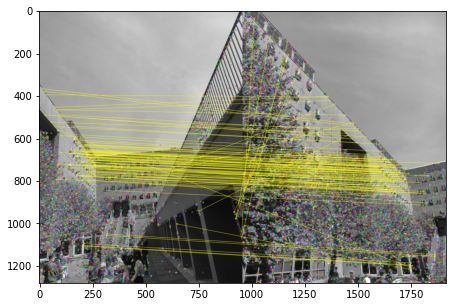

In [263]:
result = cv.drawMatches(img3, kpsb3, img1, kpsb1, matchesb_sort, 
                        None, matchColor=[255,255,0])
plt.imshow(result, cmap="gray")

In [264]:
def myHomografy(kpsA, kpsB, matches):
  kpsA = np.float32([kp.pt for kp in kpsA])
  kpsB = np.float32([kp.pt for kp in kpsB])
  
  ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
  ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

  h, status = cv.findHomography(ptsA, ptsB, cv.RANSAC,
            4)
  return h

In [265]:
H = myHomografy(kpsb3, kpsb1, matchesb_sort)

In [266]:
print(H)

[[ 4.61821210e-01  8.65500253e-02  4.29429751e+02]
 [-4.64302248e-01  7.49284118e-01  2.11391329e+02]
 [-4.80796939e-04 -1.01923856e-04  1.00000000e+00]]


Step2: applicare l'omografia alla seconda immagine

In [267]:
def myWarp(im_base, im_train, H):
  width = im_base.shape[1] + im_train.shape[1]
  height = im_base.shape[0]
  return cv.warpPerspective(im_train, H, (width, height))

In [268]:
img_final=myWarp(boat1, boat3, H)

Integrare la prima immagine

In [269]:
def myCollage(im_base, im_train_warp):
  im_train_warp[0:im_base.shape[0], 0:im_base.shape[1]] = im_base
  plt.imshow(im_train_warp, cmap="gray")

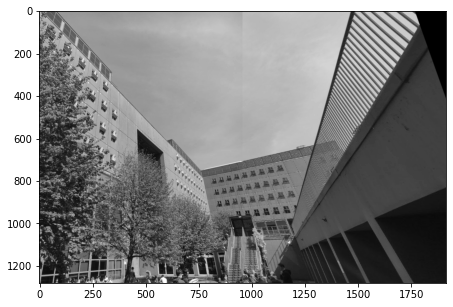

In [270]:
myCollage(boat1,img_final)
